In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import datetime, time
import numpy.linalg as lia
np.set_printoptions(threshold=np.nan, suppress=True)
import numpy.matlib
import matplotlib.pyplot as plt
from numba import jit
#from line_profiler import LineProfiler
import cProfile
%matplotlib inline
#%load_ext line_profiler

rainfall = sio.loadmat('../data/weather/prec_TRMM_GPM_daily_ws.mat')
rainfall_mat2 = rainfall['R_WS_day'].T

def date_mat2py(matlab_datenum):
    return datetime.datetime.fromordinal(int(matlab_datenum)) +     datetime.timedelta(days=matlab_datenum%1) - datetime.timedelta(days = 366)
    

def timeseries_mat2py(data_mat, date_mat, columns):
    dates = []
    for ind, d in enumerate(date_mat):
        dates.append(date_mat2py(float(d)))

    return pd.DataFrame(data_mat.T, index=dates, columns = columns)

class Results():
    def __init__(self, sib, i, geo):
        self.S = pd.DataFrame(sib[:,i.S],columns=np.arange(0,365), index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        self.I = pd.DataFrame(sib[:,i.I],columns=np.arange(0,365), index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        self.R = pd.DataFrame(sib[:,i.R],columns=np.arange(0,365), index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        self.B = pd.DataFrame(sib[:,i.B],columns=np.arange(0,365), index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        self.C = pd.DataFrame(sib[:,i.C],columns=np.arange(0,365), index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        
        self.geo = geo
        
        self.build_adm1()
        
        self.build_compare_stats()
        
    def build_adm1(self):
        self.S_adm1 = pd.DataFrame(0, columns=self.geo.adm1_name, index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        self.I_adm1 = pd.DataFrame(0, columns=self.geo.adm1_name, index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        self.R_adm1 = pd.DataFrame(0, columns=self.geo.adm1_name, index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        self.B_adm1 = pd.DataFrame(0, columns=self.geo.adm1_name, index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        self.C_adm1 = pd.DataFrame(0, columns=self.geo.adm1_name, index=pd.date_range(s.t1i, s.t2f))#.resample('W-SAT').sum()
        for ind,dept in enumerate(self.geo.adm1_name):
            for ws in np.nonzero(self.geo.ws_adm1[:,ind])[0]:
                #for date in pd.date_range(s.t1i, s.t2f):
                self.S_adm1.loc[:][dept] += self.geo.ws_adm1[ws,ind] * self.S.loc[:][ws]
                self.I_adm1.loc[:][dept] += self.geo.ws_adm1[ws,ind] * self.I.loc[:][ws]
                self.R_adm1.loc[:][dept] += self.geo.ws_adm1[ws,ind] * self.R.loc[:][ws]
                self.B_adm1.loc[:][dept] += self.geo.ws_adm1[ws,ind] * self.B.loc[:][ws]
                self.C_adm1.loc[:][dept] += self.geo.ws_adm1[ws,ind] * self.C.loc[:][ws]
        
    def build_compare_stats(self):
        self.C_adm1_w = self.C_adm1.resample('W-SAT').asfreq()
        self.I_adm1_w = self.C_adm1_w.diff()
        

class SIRB_Parameters():
    def __init__(self, theta, l, m, D, lam, rho, sigma, muB, beta0, aw):
        self.theta  = theta
        self.l      = l
        self.m      = m
        self.D      = D
        self.lam    = lam
        self.rho    = rho
        self.sigma  = sigma
        self.muB    = muB
        self.beta0  = beta0
        self.aw     = aw
        
        # Fixed Parameters
        self.gamma     = 0.2                 # rate at which people recover from cholera (day^-1)
        self.rep_ratio = 1                   # reported to total (symptomatic) cases ratio --> asymptomatic cases do not get reported

        # Parameters fixed according to litterature and former research
        self.mu          = 1/(61.4*365)              # population natality and mortality rate (day^-1)
        self.alpha       = -np.log(0.98)*self.gamma  # mortality rate due to cholera (day^-1) (2% case fatality rate)
        self.epsilon_muB = 0                         # possible seasonality in mortality of bacteria (set to 0)
        
        # From code SERRA
        self.muB_wsd = np.full((365, ), 0.029268983866374)

    @classmethod    
    def from_list(cls, param_list):
        """ Maintains compatility with enrico's prior"""
        return cls(    param_list[0],
                       param_list[1],
                       param_list[2],
                       param_list[3],
                       param_list[4],
                       1/(param_list[5]*365),
                       param_list[6],
                       param_list[7],
                       param_list[8],
                       param_list[9]
                  )

        
        
class Geography():
    def __init__(self, filename):
        self.adm1_name = ['Artibonite', 'Centre', 'Grande Anse', 'Nippes',
        'Nord', 'Nord-Est', 'Nord-Ouest', 'Ouest', 'Sud', 'Sud-Est']
        geodata = sio.loadmat(filename)
        self.nnodes = geodata['nnodes'].flatten()[0]
        self.x = geodata['X']
        self.y = geodata['Y']
        self.AD = geodata['AD']
        self.popnodes = geodata['POPnodes'].flatten()
        self.ws_adm1 = geodata['WS_dept']
        self.dist_road = geodata['dist_road']
        
    
class Setup:
    
    def __init__(self, geography, rainfall):
        #~ self.H = H
        self.geography = geography
        self.dt = 1
        self.H = np.sum(self.geography.popnodes)
        self.rainfall = rainfall

#@jit
def SIB(y,t, p, s, i): 
    rainfall = np.array(s.rainfall.loc[datetime.date.fromordinal(int(t))]) 

    temp  = np.dot(s.fluxes, y[i.B] / (y[i.B]+1))
    temp3 = np.dot(np.dot(s.HPtH, y[i.B]), p.l)
    
    TT = ((1-p.m)*y[i.B]/(1 + y[i.B]) + temp*p.m) * y[i.S] * (p.beta0 * np.exp(-(y[i.C]/s.geography.popnodes)/p.aw))
    dy = np.zeros((5 *len(s.geography.popnodes)))
    dy[i.S] = p.mu * (s.geography.popnodes - y[i.S]) - TT + p.rho*y[i.R]
    dy[i.I] = p.sigma * TT - (p.gamma + p.alpha + p.mu) * y[i.I]
    dy[i.R] = (1 - p.sigma) * TT + p.gamma * y[i.I] - (p.mu + p.rho) * y[i.R]
    dy[i.B] =  -(p.muB_wsd + p.l) * y[i.B] + (p.theta/s.geography.popnodes) * (1+p.lam * rainfall) * y[i.I] + temp3
                             
    dy[i.C] = p.sigma * TT
    return dy

class Ind():
    def __init__ (self):
        self.S = np.arange(0,365)
        self.I = np.arange(365,2*365)
        self.R = np.arange(2*365,3*365)
        self.B = np.arange(3*365,4*365)
        self.C = np.arange(4*365, 5*365)
    


import scipy.integrate

p = SIRB_Parameters.from_list([0.901111670421407,
                               0.0340324430375198,
                               0.274589893352084,
                               58.9016534494006,
                               0.619901160642942,
                               1.01068967295270,
                               0.0538198449861880,
                               0.0292689838663739,
                               0.227960466652046,
                               0.0695082468030896])   # Check OK



geography = Geography('../data/geodata/geodata.mat')

rainfall = sio.loadmat('../data/weather/prec_TRMM_GPM_daily_ws.mat')
rainfall_mat = rainfall['R_WS_day'].T

rainfall = timeseries_mat2py(rainfall['R_WS_day'], rainfall['date_list'], np.arange(365)).fillna(0)  # Check OK

s = Setup(geography, rainfall)

i = Ind()

cases = sio.loadmat('../data/cases/casedata_10Jan2017.mat') 
cases = timeseries_mat2py(cases['cases_week'], cases['date_cases_week'], s.geography.adm1_name).resample('W-SAT').sum()

s.t1i = datetime.date(2010, 10, 20)
s.t1f = datetime.date(2016, 8, 1)    # to work on IC
s.t2f = datetime.date(2016, 12, 24)  #final time of forecast
#s.t2f = datetime.date(2013, 10, 20)  #final time of forecast


fluxes=np.dot(np.exp(-s.geography.dist_road/p.D), np.diag(s.geography.popnodes)) 
np.fill_diagonal(fluxes,0)
s.fluxes = fluxes/np.matlib.repmat(np.sum(fluxes,axis=1),s.geography.nnodes,1) # check NEARLY OK
s.fluxes = sio.loadmat('../data/fluxes.mat') 
s.fluxes = s.fluxes['fluxes']

s.HPtH = lia.multi_dot([np.diag(1./s.geography.popnodes), s.geography.AD.T.todense(), np.diag(s.geography.popnodes)]) # check NEARLY OK
s.HPtH = sio.loadmat('../data/HPtP.mat') 
s.HPtH = s.HPtH['HPtH'].todense()


ic_pts = [150-1, 109-1, 119-1, 118-1]

I0 = np.round(np.minimum(
    np.insert(1100*s.geography.popnodes.take(ic_pts[1:])/np.sum(s.geography.popnodes.take(ic_pts[1:])),0,1000)\
            /(p.sigma*p.rep_ratio),
        s.geography.popnodes.take(ic_pts)))   # Tested OK

y0 = np.zeros((5 *len(s.geography.popnodes)))
y0[i.S]= s.geography.popnodes.copy()
np.put(y0, ic_pts, y0[i.S].take(ic_pts) - I0)             # Tested OK
np.put(y0, ic_pts + i.I[0], p.sigma*I0)                   # Tested OK
np.put(y0, ic_pts + i.R[0], (1-p.sigma)*I0)               # Tested OK
np.put(y0, ic_pts + i.B[0], y0[i.I].take(ic_pts)*p.theta/s.geography.popnodes.take(ic_pts)/p.muB)   # Tested OK
np.put(y0, ic_pts + i.C[0], p.sigma*I0)            # Tested OK  


t = np.arange( s.t1i.toordinal(),  s.t2f.toordinal()+1)


In [2]:
tic = time.time()    
sib = scipy.integrate.odeint(SIB, y0, t, args=(p,s,i))
print(time.time()-tic)

1464.963406085968


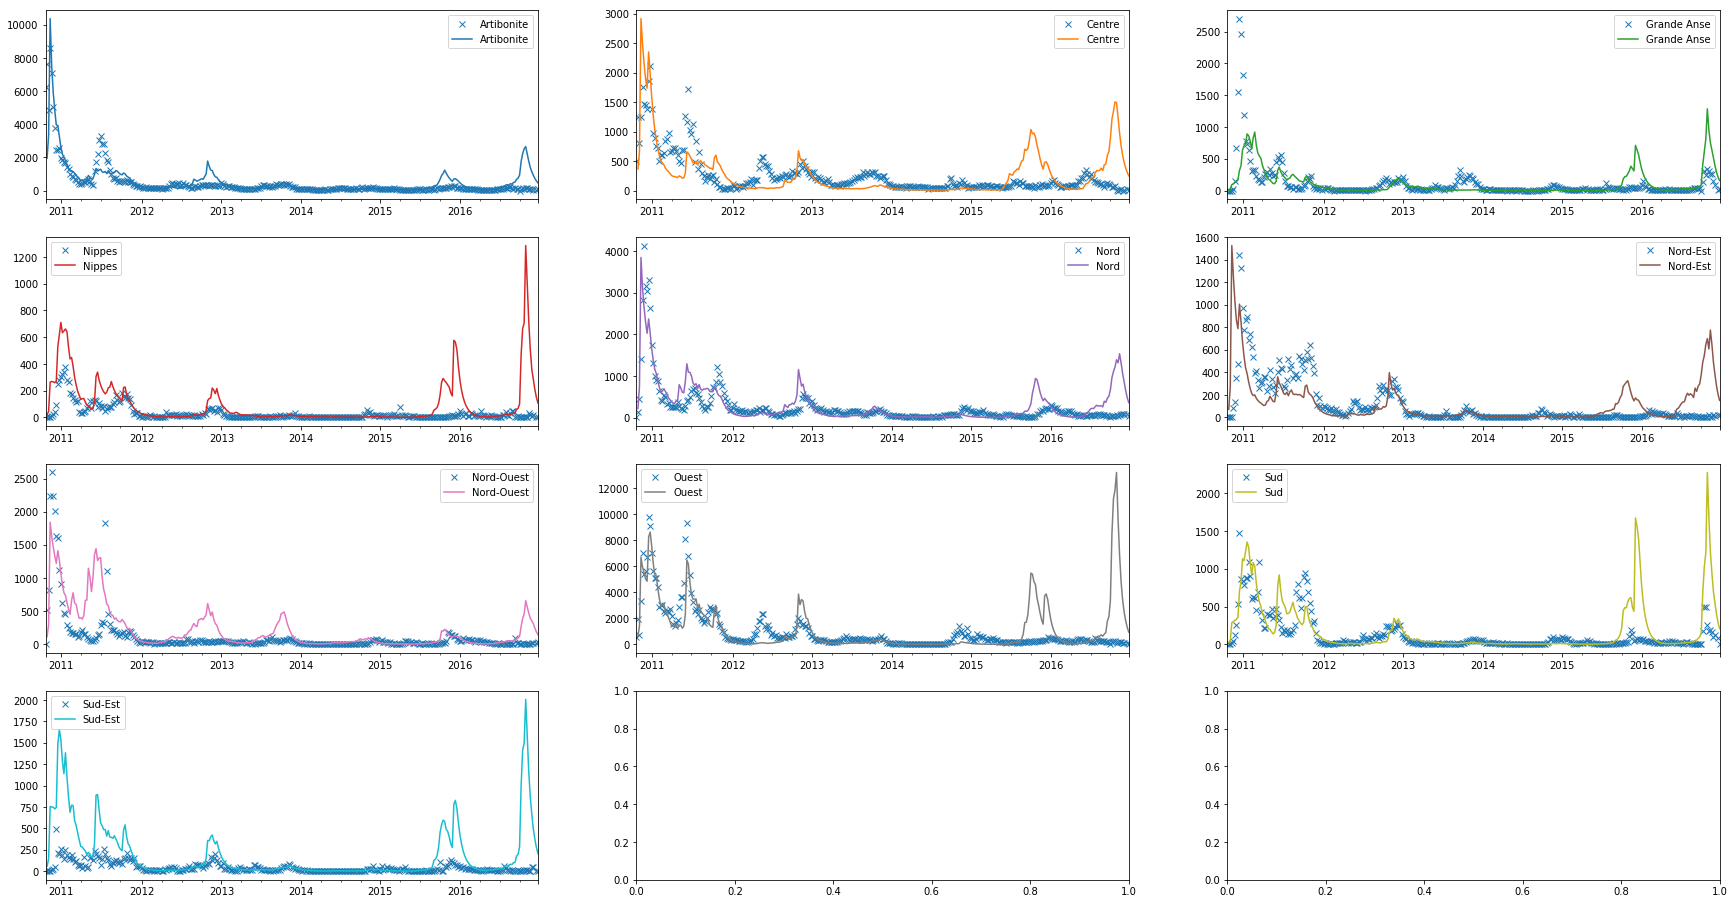

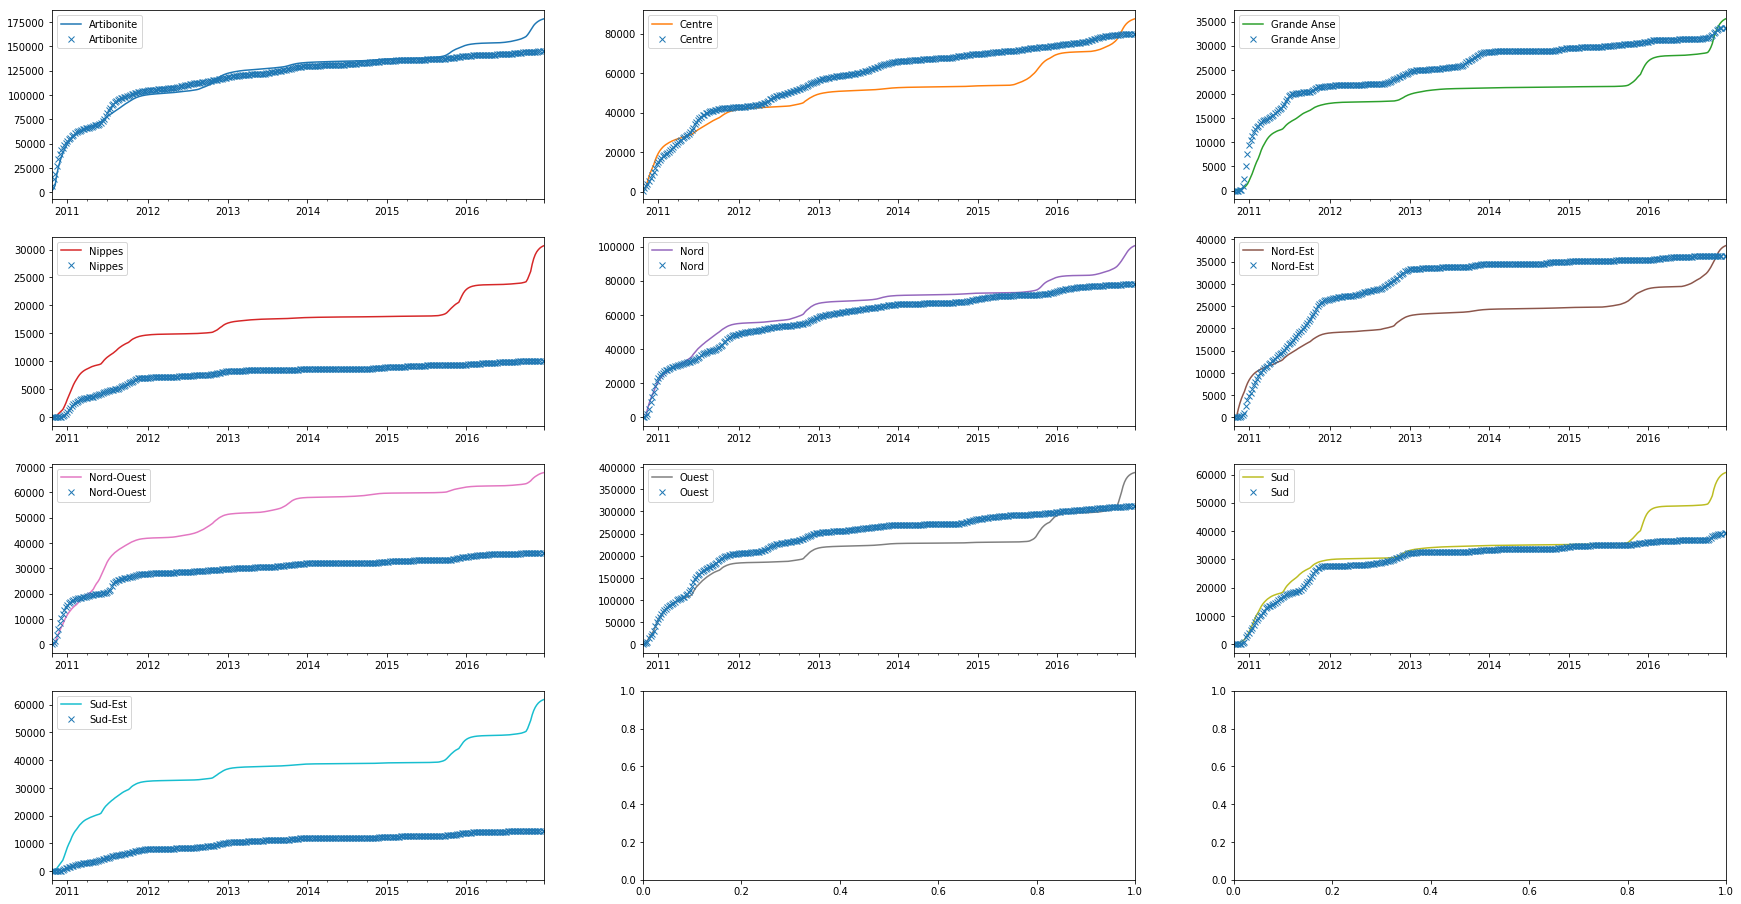

In [4]:
r = Results(sib,i,s.geography)
plt.tight_layout();
#r.S_adm1.plot(subplots=True, layout=(4, 3), figsize=(30,16));
fig, axes = plt.subplots(4, 3, figsize=(30, 16), squeeze = True);
axes = axes.flatten()
axes = axes[:-2]
cases.plot(subplots=True, style='x', ax = axes, xlim=(s.t1i, s.t2f));
r.I_adm1_w.plot(subplots=True, ax=axes, xlim=(s.t1i, s.t2f) );
#r.R_adm1.plot(subplots=True, layout=(4, 3), figsize=(30,16));
#r.B_adm1.plot(subplots=True, layout=(4, 3), figsize=(30,16));
fig, axes = plt.subplots(4, 3, figsize=(30, 16), squeeze = True);
axes = axes.flatten()
axes = axes[:-2]
r.C_adm1_w.plot(subplots=True, ax=axes, xlim=(s.t1i, s.t2f));
cases.cumsum().plot(subplots=True, style='x', ax = axes, xlim=(s.t1i, s.t2f));

In [13]:
        for ind,dept in enumerate(geography.adm1_name):
            for ws in np.nonzero(geography.ws_adm1[:,ind])[0]:
                #for date in pd.date_range(s.t1i, s.t2f):
                r.S_adm1.loc[:][dept] += r.S.loc[:][ws]

In [16]:
np.nonzero(geography.ws_adm1[:,ind])[0]

array([ 47,  48,  60,  61,  62,  63,  66,  70,  73,  94,  95,  96,  97,
        98, 115, 122, 123, 151, 164, 165, 181, 188, 201, 205, 217, 229,
       235, 236, 247, 248, 249, 250, 252, 253, 256, 276, 277, 289, 346,
       347, 349, 354, 356, 357, 358, 359, 361, 363])

In [20]:
geography.ws_adm1[49,ind]

0.0

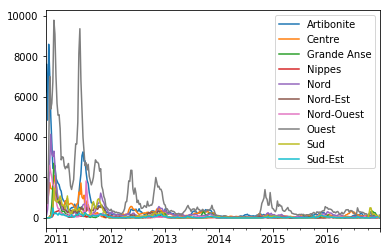

In [24]:
cases.plot()

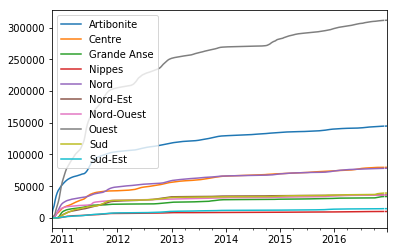

In [25]:
cases.cumsum().plot()